In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='error', category=DataConversionWarning)

import pandas as pd
import psycopg2 as pg
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples,silhouette_score

In [2]:
# set up configuration
host = "localhost"
port = "5432"
database = "postgres"
user = "postgres"
password = "kagome235"
setting = "dbname=" + database + " user=" + user + " host=" + host + " port=" + port + " password=" + password
engine = pg.connect(setting)

In [3]:
query = f"""
	select
        order_id
        , price
        , freight_value
	from 
		olist_order_items_dataset_csv ooidc 
    """
df_read = pd.read_sql(query, con=engine)

C:\Users\mamad\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df_read

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,55.99,8.72


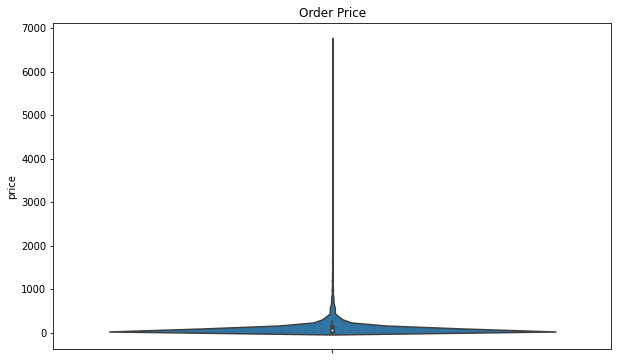

In [7]:
plt.figure(figsize=(10,6))
plt.title("Order Price")
sns.axes_style("dark")
sns.violinplot(y=df_read["price"])
plt.show()

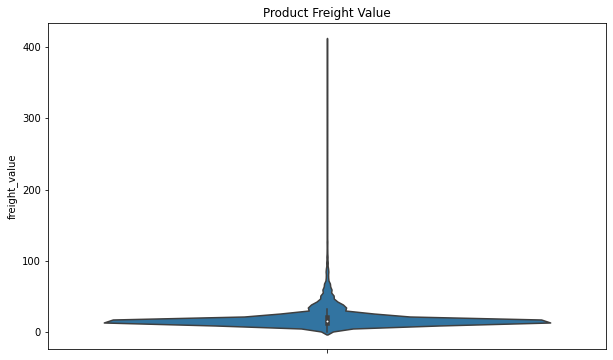

In [8]:
plt.figure(figsize=(10,6))
plt.title("Product Freight Value")
sns.axes_style("dark")
sns.violinplot(y=df_read["freight_value"])
plt.show()

In [9]:
orders = df_read.groupby('order_id').count()[1:]['price']

In [11]:
orders = pd.DataFrame(orders).sort_values('price').reset_index()[::-1][:10]

In [15]:
df_train = df_read[(df_read.freight_value >=40) & (df_read.price >=40)]

In [16]:
df_train

,order_id,price,freight_value
7,000576fe39319847cbb9d288c5617fa6,810.00,70.75
22,000f25f4d72195062c040b12dce9a18a,119.99,44.40
39,0017afd5076e074a48f1f1a4c7bac9c5,809.10,44.29
59,00254baeb6c932b0a8aeead91fbd02b5,149.90,43.11
73,002b430ff89b3a24c31a1170acbbedea,199.99,65.56
...,...,...,...
112613,ffebd80e3291e811c308365936897efd,129.90,51.20
112634,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14
112635,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14
112637,fffa82886406ccf10c7b4e35c4ff2788,229.90,44.02


In [17]:
df_train.iloc[:,1:]

,price,freight_value
7,810.00,70.75
22,119.99,44.40
39,809.10,44.29
59,149.90,43.11
73,199.99,65.56
...,...,...
112613,129.90,51.20
112634,180.00,48.14
112635,180.00,48.14
112637,229.90,44.02


In [18]:
start_loop = datetime.datetime.now()
wcss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_train.iloc[:,1:])
    wcss.append(kmeans.inertia_)
stop_loop = datetime.datetime.now()
print("[Total Run Time]:", (stop_loop - start_loop).seconds)

[Total Run Time]: 7


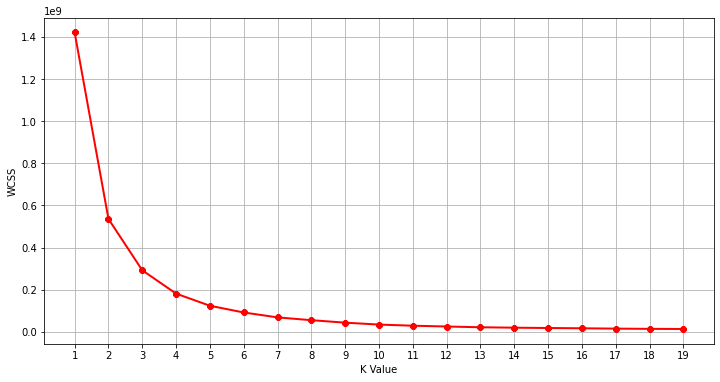

In [19]:
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

In [20]:
km = KMeans(n_clusters=5)
clusters = km.fit_predict(df_train.iloc[:,1:])
df_train["label"] = clusters

C:\Users\mamad\AppData\Local\Temp\ipykernel_14356\3228651075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = clusters


In [21]:
df_train

,order_id,price,freight_value,label
7,000576fe39319847cbb9d288c5617fa6,810.00,70.75,2
22,000f25f4d72195062c040b12dce9a18a,119.99,44.40,0
39,0017afd5076e074a48f1f1a4c7bac9c5,809.10,44.29,2
59,00254baeb6c932b0a8aeead91fbd02b5,149.90,43.11,0
73,002b430ff89b3a24c31a1170acbbedea,199.99,65.56,0
...,...,...,...,...
112613,ffebd80e3291e811c308365936897efd,129.90,51.20,0
112634,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14,0
112635,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14,0
112637,fffa82886406ccf10c7b4e35c4ff2788,229.90,44.02,0


In [22]:
df_train.groupby('label').count()

,order_id,price,freight_value
label,,,
0,5275,5275,5275
1,433,433,433
2,1325,1325,1325
3,157,157,157
4,17,17,17


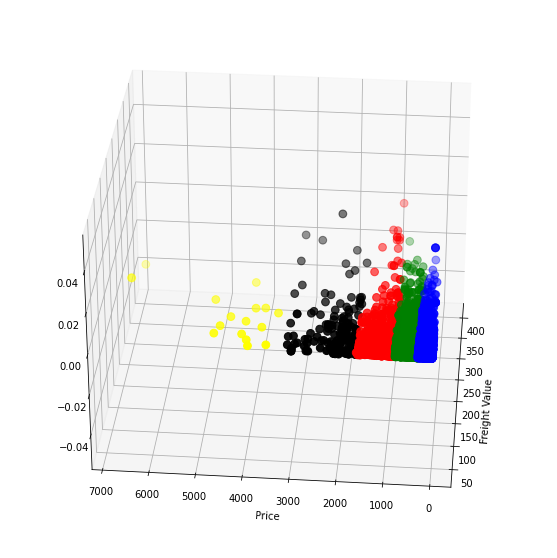

In [23]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train.freight_value[df_train.label == 0], df_train.price[df_train.label == 0], c='blue', s=60)
ax.scatter(df_train.freight_value[df_train.label == 1], df_train.price[df_train.label == 1], c='red', s=60)
ax.scatter(df_train.freight_value[df_train.label == 2], df_train.price[df_train.label == 2], c='green', s=60)
ax.scatter(df_train.freight_value[df_train.label == 3], df_train.price[df_train.label == 3], c='black', s=60)
ax.scatter(df_train.freight_value[df_train.label == 4], df_train.price[df_train.label == 4], c='yellow', s=60)
ax.view_init(30, 185)
plt.xlabel("Freight Value")
plt.ylabel("Price")
plt.show()

In [24]:
start_loop = datetime.datetime.now()
with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    warnings.filterwarnings('error')
    silhoutte_result = {}
    
    for n_clusters in range(2,50):
        
        try:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(df_train.iloc[:,1:4])
            
            centers = clusterer.cluster_centers_
            
            score = silhouette_score(df_train.iloc[:,1:4],preds)
            
            silhoutte_result.update({n_clusters: score})
        except Warning:
            print("[Convergence Warning] : ", n_clusters)
            break
stop_loop = datetime.datetime.now()
print("[Total Run Time]:", (stop_loop - start_loop).seconds)

[Total Run Time]: 205


In [25]:
max(silhoutte_result, key=silhoutte_result.get)

2

In [26]:
km = KMeans(n_clusters=49)
clusters = km.fit_predict(df_train.iloc[:,1:])
df_train["label_2"] = clusters

C:\Users\mamad\AppData\Local\Temp\ipykernel_14356\1496418172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label_2"] = clusters


In [27]:
df_train

,order_id,price,freight_value,label,label_2
7,000576fe39319847cbb9d288c5617fa6,810.00,70.75,2,10
22,000f25f4d72195062c040b12dce9a18a,119.99,44.40,0,38
39,0017afd5076e074a48f1f1a4c7bac9c5,809.10,44.29,2,10
59,00254baeb6c932b0a8aeead91fbd02b5,149.90,43.11,0,41
73,002b430ff89b3a24c31a1170acbbedea,199.99,65.56,0,37
...,...,...,...,...,...
112613,ffebd80e3291e811c308365936897efd,129.90,51.20,0,41
112634,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14,0,37
112635,fff8287bbae429a99bb7e8c21d151c41,180.00,48.14,0,37
112637,fffa82886406ccf10c7b4e35c4ff2788,229.90,44.02,0,30
